# Задание №2: Фрактальное сжатие

**Максимальное количество баллов — 35** (с доп. баллами может быть больше)

## Правила сдачи
1. У каждого подзадания указано максимальное количество баллов, которые можно за него получить
2. Итоговый балл за задание складывается из всех полученных баллов за подзадания
3. Баллы за подзадание выставляются на усмотрение проверяющего, полный балл можно получить только в случае полного выполнения условий подзадания
4. Для сдачи необходимо в Anytask загрузить Jupyter-ноутбук с выполненными подзаданиями
5. В сданном Jupyter-ноутбуке не должны быть удалены условия подзаданий, в противном случае максимальная оценка за каждое подзадание без условия делится пополам
6. Доп. баллы можно получить за примеры неправильно работющего алогритма, но выдающего красивые картинки. Для этого нужно скинуть картинку и тот самый код, который генерирует картинку. В зависимости от того, насколько пример понравится проверяющему, может быть начислено от 0 до +5 дополнительных баллов.

## Немного теории
Алгоритм описан в главе про [сжатие изображений](https://compression.ru/book/part2/part2__3.htm#_Toc448152512).

### Определения
**Ранговый блок**: если исходное изображение разбивается на непересекающиеся блоки одинакового размера, замощающие всё изображение, то каждый такой блок называется _ранговым_; имеют меньший размер, чем доменные блоки.

**Доменный блок**: если исходное изображение разбивается блоки одинакового размера, которые могут и пересекаться, то каждый такой блок называется _доменным_; имеют больший размер, чем ранговые блоки.

**Идея алгоритма**:

При сжатии:
1. для каждого рангового блока найти наиболее похожий на него доменный блок (с учётом поворотов и симметрии)
2. выполнить преобразование яркости
3. в качестве сжатого изображения выступают коэффициенты преобразования ранговых блоков, эффективно записанные в файл (строку)

При декомпрессии:
1. Прочитать файл (строку), извлечь коэффициенты преобразований
2. Применить преобразования к исходному изображению (обычно просто серое) пока результат не стабилизируется

In [1]:
# Standard Python Library

import os
import itertools

from collections import namedtuple

# Additional Modules

import matplotlib.pyplot as plt
import numpy as np

from skimage import io
from skimage import data, img_as_float64
from skimage.measure import compare_psnr, compare_ssim, compare_mse
from skimage.transform import resize
from skimage.color import rgb2gray, rgb2yuv

from tqdm import tqdm

Первым делом нужно загрузить картинку

In [2]:
lenna_rgb_512x512 = io.imread('test_files/lenna.bmp')
lenna_rgb_256x256 = resize(lenna_rgb_512x512, (256, 256))
lenna_gray_256x256 = np.rint(rgb2gray(lenna_rgb_256x256) * 255).astype('uint8')

`plt` — модуль для рисования графиков и всего остального

Очень удобная штука, будем пользоваться ей довольно часто

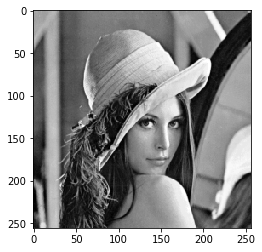

In [40]:
plt.imshow(lenna_gray_256x256, cmap='gray')

## Общие функции
В следующих клетках описаны функции и классы, которые будут использоваться **вами** при выполнении следующих подзаданий. Стоит с ними подробно ознакомиться, понять, что они делают, и поэкспериментировать.

In [6]:
BlockTransform = namedtuple('BlockTransform', ['x', 'y', 'di', 'tr'])
FractalCompressionParams = namedtuple(
    'FractalCompressionParams', [
        'height',
        'width',
        'is_colored',
        'block_size',
        'spatial_scale',
        'intensity_scale',
        'stride'
    ]
)

In [7]:
def derive_num_bits(length, stride):
    return np.ceil(np.log2(length / stride)).astype(int)

In [8]:
def is_colored(image):
    if len(image.shape) == 2:
        return False
    elif len(image.shape) == 3 and image.shape[-1] == 3:
        return True
    else:
        message = 'Invalid shape of the image: `{}`'
        raise ValueError(message.format(image.shape))

### [6 баллов] Функция для нахождения наилучшего преобразования рангового блока

#### Описание

на входе функции подаются:
* исходное Ч/Б изображение (`image`)
* уменьшенное изображение (`resized_image`)
* координаты рангового блока (`x`, `y`)
* размер блока (`block_size`)
* шаг, через сколько пикселей перескакивать при переборе (`stride`)

на выходе функция должна выдавать:
* лучшее преобразование в смысле MSE, объект типа `BlockTransform`

#### Условие
* (5) Реализовать функцию
* (1) Протестировать

In [41]:
def find_block_transform(image, resized_image, x, y, block_size, stride):
    '''Find best transformation for given rank block.
    
    Parameters
    ----------
    image : np.array
        Source B/W image.

    resized_image: np.array
        Resized source image.

    x, y: int, int
        Coordinates of the rank block.
    
    block_size: int
        Size of rank block.

    stride: int
        Vertical and horizontal stride for domain block search.

    Returns
    -------
    best_transform: BlockTransform
        Best transformation.
    '''
    
    # YOUR CODE HERE

    return best_transform

### [6 баллов] Применение IFS к изображению

#### Описание

на входе функции подаются:
* исходное изображение (`image`)
* уменьшенное изображение (`resized_image`)
* IFS, массив объектов типа `BlockTransform` (`transforms`)
* размер блока (`block_size`)

на выходе функция должна выдавать:
* картинку после одинарного применения IFS

#### Условие
* (5) Реализовать функцию
* (1) Протестировать

In [42]:
def perform_transform(image, resized_image, transforms, block_size):
    '''Perform IFS on given image.
    
    Parameters
    ----------
    image : np.array
        Source image.

    resized_image: np.array
        Resized source image.

    transforms: list of BlockTransform's
        Given IFS, Iterated Function System
    
    block_size: int
        Size of rank block.

    Returns
    -------
    transformed_image: np.array
        Transformed image.
    '''
    
    # YOUR CODE HERE

    return transformed_image

### [9 баллов] Класс, реализующий интерфейс битового массива
Он понадобится для преобразования найденной IFS в строку, чтобы записать сжатый файл на диск.

#### Условие
* (4) Реализовать методы `push` и `pop`
* (2) Протестировать (написать 3 теста для проверки корректности работы класса)
* (3) Использовать его для фрактального сжатия 

In [10]:
class BitBuffer:
    '''Class that provides storing and and reading integer numbers 
    in continuous bytearray.

    Parameters
    ----------
    buffer : bytearray, optional (default=None)
        Input bytearray, for initialization.

    Attributes
    ----------
    _buffer : bytearray
        Bytearray that can contain any information.

    Examples
    --------
    >>> buffer = BitBuffer()
    >>> buffer.push(1, 1)
    >>> x = buffer.pop(1)
    >>> print(x)
    1
    >>> buffer.push(125, 18)
    >>> x = buffer.pop(18)
    >>> print(x)
    125
    >>> buffer.push(5, 3)
    >>> x = buffer.pop(3)
    >>> print(x)
    5

    >>> dy = transform.y // stride
    >>> buffer.push(dy, self._num_bits_ver)
    '''

    def __init__(self, buffer=None):
        self._buffer = buffer or bytearray()
        
        # YOUR CODE HERE

    def to_bytearray(self):
        '''Convert to bytearray.
    
        Returns
        -------
        buffer: bytearray
            Bytearray that contains all data.
        '''

        return self._buffer

    def push(self, x, n_bits):
        '''Push given integer to buffer.
    
        Parameters
        ----------
        x : int
            Input number.

        n_bits: int
            Number of bits for store input number,
            should be greater than log2(x).
        '''
        
        # YOUR CODE HERE
            
    def pop(self, n_bits):
        '''Pop n_bits from buffer and transform it to a number.
    
        Parameters
        ----------
        n_bits: int
            Number of bits for pop from buffer.

        Returns
        -------
        x: int
            Extracted number.
        '''

        # YOUR CODE HERE

        return x

### [14 баллов] Класс, реализующий интерфейс архиватора изображений

#### Условие
* (5) Реализовать все методы, **ограничение времени работы**: алгоритм не должен работать дольше 5 минут на изображении 256x256 с `block_size`=16 и `stride`=4 (на Core i5 2.3 GHz), иначе за это задание будет поставлено 0 баллов.
* (2) Проверить корректность работы (написать 3 теста, доказывающих корректность работы)
* (4) Соптимизировать алгоритм так, чтобы на изображении 256x256 при `block_size`=16 и `stride`=4 время работы было не больше 40 с (на Core i5 2.3 GHz)
* (3) Добавить поддержку сжатия цветных изображений (сначала перевести в YUV, все каналы сжимать как отдельные ЧБ изображения, при этом каналы UV сжимать с в 2 раза большим `stride`)

#### Примечание
Если вы не реализовывали `BitBuffer`, то можно из метода `compress` возвращать `params, transformations`, и принимать их же в методе `decompress`. Баллы в этом подзадании за это сниматься не будут.

In [22]:
class FractalCompressor:
    '''Class that performs fractal compression/decompression of images.

    Attributes
    ----------
    _num_bits_ver : int
        Number of bits for store VERTICAL OFFSET for each transformation.
    
    _num_bits_hor : int
        Number of bits for store HORIZONTAL OFFSET for each transformation.
        
    _num_bits_pix : int
        Number of bits for store INTENSITY OFFSET for each transformation.
        
    _num_bits_tfm : int
        Number of bits for store TRANFORMATION INDEX for each transformation.

    Examples
    --------
    >>> comp = FractalCompressor()
    >>> compressed_image = comp.compress(image, block_size=8, stride=2)
    >>> decompressed_image = comp.decompress(compressed_image, num_iters=9)
    >>> yet_another_compressed_image = comp.compress(image, 8, 4, 0.5, 0.7)
    >>> yet_another_decompressed_image = comp.compress(yet_another_compressed_image, 5)
    '''

    def __init__(self):
        self._num_bits_ver = None
        self._num_bits_hor = None
        self._num_bits_pix = derive_num_bits( # YOUR CODE HERE )
        self._num_bits_tfm = derive_num_bits( # YOUR CODE HERE )
    
    def _add_header(self, buffer, params):
        '''Store header in buffer.
    
        Parameters
        ----------
        buffer: BitBuffer
            
        params: FractalCompressionParams
            Parameters that should be stored in buffer.

        Note
        ----
        This method must be consistent with `_read_header`.
        '''
        
        # YOUR CODE HERE
        
    def _read_header(self, buffer):
        '''Read header from buffer.
    
        Parameters
        ----------
        buffer: BitiBuffer

        Returns
        -------
        params: FractalCompressionParams
            Extracted parameters.
            
        Note
        ----
        This method must be consistent with `_add_header`.
        '''
        
        # YOUR CODE HERE
            
        return params
    
    def _add_to_buffer(self, buffer, transform, stride):
        '''Store block transformation in buffer.
    
        Parameters
        ----------
        buffer: BitBuffer

        transform: BlockTransform
            
        stride: int
            Vertical and horizontal stride for domain block search.

        Note
        ----
        This method must be consistent with `_read_transform`.
        '''
        
        # YOUR CODE HERE
        
    def _read_transform(self, buffer, stride):
        '''Read block transformation from buffer.
    
        Parameters
        ----------
        buffer: BitBuffer

            
        stride: int
            Vertical and horizontal stride for domain block search.
            
        Returns
        -------
        transform: BlockTransform
            Extracted block transformation.

        Note
        ----
        This method must be consistent with `_add_to_buffer`.
        '''

        # YOUR CODE HERE

        return transform
    
    def _ifs2buf(self, params, transformations):
        '''Store compression parameters and IFS in buffer.
    
        Parameters
        ----------
        params: FractalCompressionParams
            Parameters of the compression.

        transformations: list of BlockTransform's
            Given IFS.

        Returns
        -------
        buffer: BitBuffer

        Note
        ----
        This method must be consistent with `_buf2ifs`.
        '''
        
        # FEEL FREE TO CHANGE CODE BELOW

        buffer = BitBuffer()
        self._add_header(buffer, params)
        for t in transformations:
            self._add_to_buffer(buffer, t, params.stride)
        return buffer
    
    def _buf2ifs(self, buffer):
        '''Store compression parameters and IFS in buffer.
    
        Parameters
        ----------
        buffer: BitBuffer

        Returns
        -------
        params: FractalCompressionParams
            Extracted compression parameters.

        transforms: list of BlockTransform's
            Extracted IFS.

        Note
        ----
        This method must be consistent with `_ifs2buf`.
        '''

        # FEEL FREE TO CHANGE CODE BELOW

        params = self._read_header(buffer)
        
        self._num_bits_ver = derive_num_bits(params.height, params.stride)
        self._num_bits_hor = derive_num_bits(params.width, params.stride)
        
        num_transforms = int(params.height * params.width / params.block_size ** 2)
        transforms = [
            self._read_transform(buffer, params.stride)
            for _ in range(num_transforms)
        ]
        
        return params, transforms
        
        
    def compress(self, image, block_size=8, stride=1,
                 spatial_scale=0.5, intensity_scale=0.75):
        '''Compress input image
        
        Parameters
        ----------
        image : np.array
            Source image.

        block_size: int, optional (default=8)
            Size of rank block.

        stride: int, optional (default=1)
            Vertical and horizontal stride for domain block search.
        
        spatial_scale : float, optional (default=0.5)
            ({rank block size} / {domain block size}) ratio, must be <1.
        
        intensity_scale : float, optional (default=0.75)
            Reduce coefficient for image intensity.

        Returns
        -------
        byte_array: bytearray
            Compressed image.
            
        Note
        ----
        This method must be consistent with `decompress`.
        '''
        
        # YOUR CODE HERE
        
        transformations = []
        for x, y in tqdm(itertools.product(xs, ys), total=len(xs)*len(ys)):
            transform = find_block_transform(
                source_image, resized_image,
                x, y, block_size, stride
            )
            transformations.append(transform)
            
        buffer = self._ifs2buf(params, transformations)
        return buffer.to_bytearray()
    
    def decompress(self, byte_array, num_iters=10):
        '''Compress input image
        
        Parameters
        ----------
        byte_array: bytearray
            Compressed image.

        num_iters: int, optional (default=10)
            Number of iterations to perform IFS.

        Returns
        -------
        image: np.array
            Decompressed image.
            
        Note
        ----
        This method must be consistent with `compress`.
        '''
        
        # YOUR CODE HERE
        
        return image

## Пробуем применить FractalCompressor

In [23]:
comp = FractalCompressor()

In [24]:
result_16x4 = comp.compress(lenna_gray_256x256, block_size=16, stride=4)

256it [00:35,  7.13it/s]


Размер сжатого изображения в байтах == длина полученного массива `bytearray`

In [27]:
len(result_16x4)

777

### Эволюция изображения при декомпрессии
Выглядит как увеличение фотографии в CSI: Место прреступления

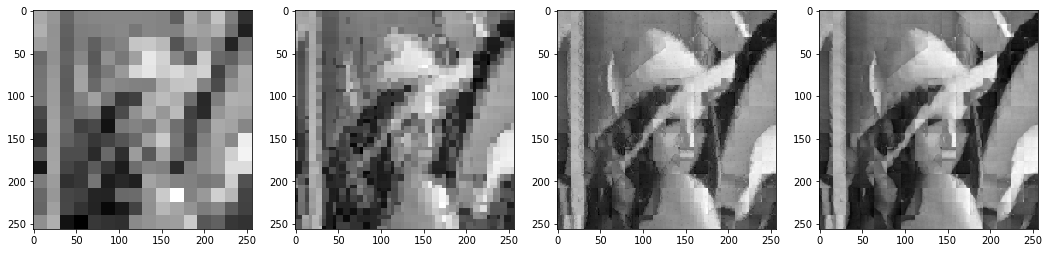

In [28]:
n_iters = [1, 2, 4, 8]

imgs = [comp.decompress(result_16x4, n) for n in n_iters]
_, axs = plt.subplots(ncols=len(imgs), figsize=(18, 6))
for index in range(len(imgs)):
    axs[index].imshow(imgs[index], cmap='gray')

plt.show()

### Поиграемся с параметрами сжатия
Понятно, что при увеличении перебора мы, во-первых, увеличиваем время вычислений, а во-вторых, улучшаем итоговое качество изображения после сжатия и декомпрессии.

Чтобы увеличить перебор можно уменьшить размер шага `stride` или уменьшить размер доменного блока `block_size`. Но не рекомендуется делать блок размером меньше 4х4.

In [29]:
result_16x2 = comp.compress(lenna_gray_256x256, block_size=16, stride=2)

256it [02:06,  2.06it/s]


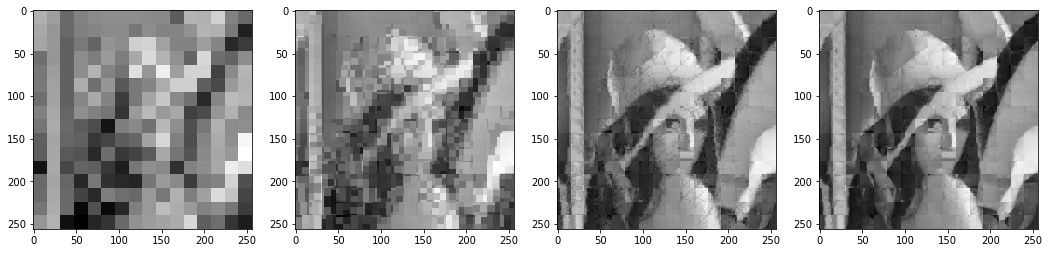

In [36]:
n_iters = [1, 2, 4, 8]

imgs = [comp.decompress(result_16x2, n) for n in n_iters]
_, axs = plt.subplots(ncols=len(imgs), figsize=(18, 6))
for index in range(len(imgs)):
    axs[index].imshow(imgs[index], cmap='gray')

plt.show()

In [37]:
result_8x4 = comp.compress(lenna_gray_256x256, block_size=8, stride=4)

1024it [03:00,  6.24it/s]


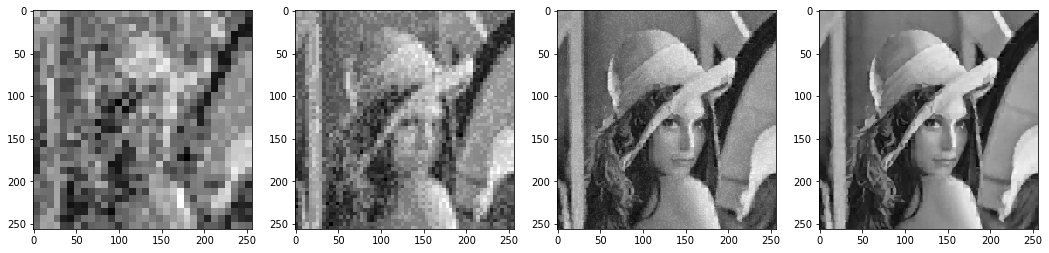

In [38]:
n_iters = [1, 2, 4, 8]

imgs = [comp.decompress(result_8x4, n) for n in n_iters]
_, axs = plt.subplots(ncols=len(imgs), figsize=(18, 6))
for index in range(len(imgs)):
    axs[index].imshow(imgs[index], cmap='gray')

plt.show()

In [39]:
result_8x2 = comp.compress(lenna_gray_256x256, block_size=8, stride=2)

1024it [1:57:16,  1.58it/s]


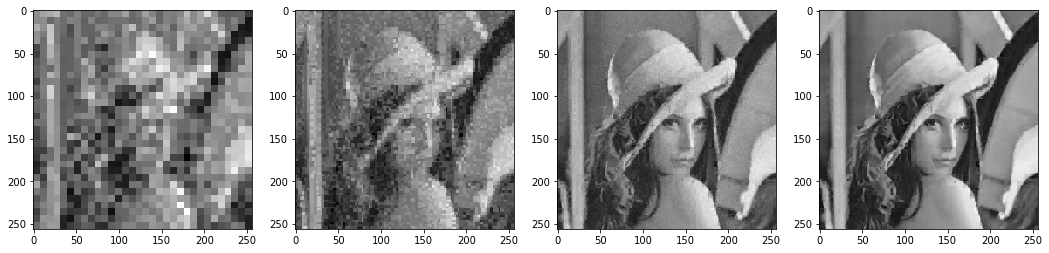

In [178]:
n_iters = [1, 2, 4, 8]

imgs = [comp.decompress(result_8x2, n) for n in n_iters]
_, axs = plt.subplots(ncols=len(imgs), figsize=(18, 6))
for index in range(len(imgs)):
    axs[index].imshow(imgs[index], cmap='gray')

plt.show()

## Построим график качества
Качество в данном случае будет измеряться по PSNR (а значит в децибелах).

Это базовый график для понимания соотношения между временем вычислений и качеством, получаемым на выходе. Можно посмотреть, как он будет меняться в зависимости от количества итераций при декомпрессии, например.

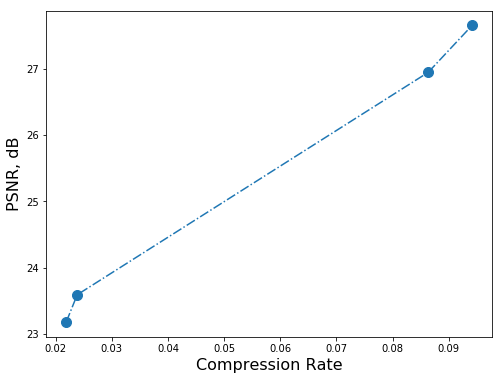

In [190]:
n_iters = 16

lenna_decomp_16x4 = comp.decompress(result_16x4, n_iters)
lenna_decomp_16x2 = comp.decompress(result_16x2, n_iters)
lenna_decomp_8x4  = comp.decompress(result_8x4, n_iters)
lenna_decomp_8x2  = comp.decompress(result_8x2, n_iters)

compression_rates = np.array([
    len(result_16x4), len(result_16x2),len(result_8x4),len(result_8x2)
]) / lenna_gray_256x256.size

psnrs = [
    compare_psnr(lenna_gray_256x256, lenna_decomp_16x4),
    compare_psnr(lenna_gray_256x256, lenna_decomp_16x2),
    compare_psnr(lenna_gray_256x256, lenna_decomp_8x4),
    compare_psnr(lenna_gray_256x256, lenna_decomp_8x2),
]

_, ax = plt.subplots(figsize=(8, 6))

ax.plot(compression_rates, psnrs, marker='o', ms=10, ls='-.')
ax.set_xlabel('Compression Rate', fontsize=16)
ax.set_ylabel('PSNR, dB', fontsize=16)

plt.show()